# Decision Trees

In the last module, we fit a linear model to the Boston Housing Data. However, even after transforming our variables we did not achieve a very good fit. This was because most of our variables did not display a linear relationship to our response variable medv. 

Decision trees are a good option for modeling non-linear data in engineering research because they offer increased flexibility while still being **interpretable**. Many machine learning models, such as neural networks, are what we call "black box algorithms." We put data in and we get predictions out, but we have little insight into how the model is making predictions. The model is a "black box" that we can not see into. <br>
Decision trees, on the other hand, are interpretable because they output a model we can examine and understand. We can look at the tree and see exactly how each decision is being made. This has many advantages from validating our model (we can look over the decisions and check that they are logical) to providing insight into our data (we can learn things from studying the tree).

## Decision Tree Architecture
Decision trees are made up of decision points called nodes. At each node, the tree splits based on one variable. For example the first node (referred to as the root) of the tree generated below splits at the variable rm. The tree predicts that if rm $<=$ 6.92, then medv is less than 22.538. However, if rm > 6.92, then medv is greater than 22.538. If you follow the tree to the left, the next split is on the lstat variable. <br>
At each node, the algorithm will loop through each variable to determine which variable would produce the best split. The best split is classified as the split that would produce teh lowest mean squared error (MSE) in the predictions. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import cross_val_score

## Test and Training Data

Decision trees (along with many other machine learning methods) are prone to over-fitting, a phenomena that occurs when the model learns the data TOO well. If you allow your decision tree to become too complex, it will essentially memorize the answer to each individual data point instead of representing general trends. In this way the model can achieve near-perfect accuracy on the data it is trained on while handling new data poorly. <br>
For this reason, it is essential to set aside a test dataset to evaluate our model on. Below we use the train_test_split() function to split our 20% of our data into x_test and y_test. We will train the model using x_train and y_train and only use the test datasets to evaluate the model. 

In [8]:
# Read in data and split into testing and training
df = pd.read_csv("BostonHousing.csv")
x = df.drop(["medv"], axis = 1)
y = df["medv"]

x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.2, random_state=42)

## Fitting a Tree
Below we use DecisionTreeRegressor from sklearn.tree to fit an initial model. The only parameter we specify is the random_state. Without other parameters specified, the tree will default to growing without bound, splitting and splitting until it can split no more (resulting in a very over-grown over-fit tree). We will rectify this in the next step. 

## Random State
Functions in python that involve chance/variability will often let you set the random_state. The test_train_split function we used in the previous cell randomly selected out 20% of the data each time in runs. If we do not specify the random_state, it will select out a different 20% of the data each time we run the cell. To ensure that our results are consistent and comparable over time, we set the random state to an integer. This ensures that each time the cell is run it will split the data in the same way. Which integer we pick is not important, it should just be consistent. 

### Random State in DecisionTrees
In DecisionTreeRegressor(), the random state determines which variable is chosen when there are two variables that would produce equally good splits. The decision tree we build below is quite sensitive to the random state. This indicates that there are several variables which split the data in similar ways (remember the multicollinearity we saw in the last module) and that our tree is over-fit and not consistently generalizing well to new data (the test dataset).


In [3]:
# Initialize the model
model = DecisionTreeRegressor(random_state=32)  #try 22 and 18

# Train the model on numerical data
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 11.811274509803921


## Looking at Our Tree

We can look at our tree structure by exporting the model and using graphviz to display it. <br>In each node the first line shows what variable the node split on and at what value it split. Cases were the variable is equal to or less than the state value are sent to the left. <br> The second line lists the squared_error fo the node. This is the mean square error (MSE) of the data points in the node. It is essentially what the MSE of the model would be if it stopped at that node. <br> The third line lists the number of samples or data points that fall into the category represented by that node. The last line lists the value of the response variable assigned to that samples in the node (what the model predicts medv to be fro data points in that part of the tree).

With this information in mind, scroll through the generate graphic and see if you can make sense of it. Despite decision trees being "interoperable," this tree is so large that we have lost any simple explanation of what is happening to our data. If you scroll to the bottom, you will see that each leaf node (nodes at the end/bottom of the tree) has only one data point in is and a MSE of 0. In the next step we will put boundaries on how far the tree can split in order to rectify this. 

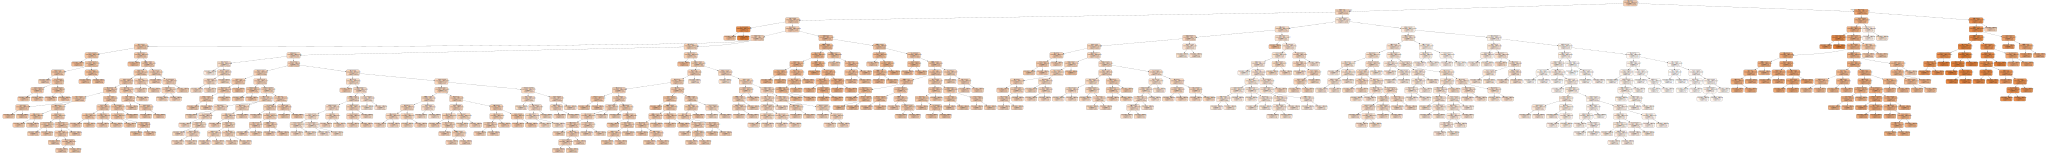

In [4]:
# Export tree structure
dot_data = export_graphviz(
    model, out_file=None, feature_names=x_train.columns, 
    filled=True, rounded=True, special_characters=True
)

# Display using graphviz
graph = graphviz.Source(dot_data)
graph  # Displays the tree in Jupyter Notebook

## Decision Tree Hyperparameters
Hyperparameters are model setting that determine how you model learns data. Below we will configure 3 hyperparmeters that will control our tree's growth. 

**max_depth:** this sets how deep, or how many layers down the tree can grow. Depending on the complexity of your data, a good number for max_depth may range from 3-10 with smaller numbers meaning a less complex tree
<br> **min_sample_split:** this sets the minimum amount of samples that must be in a node for your tree to consider splitting a node. The higher the min_sample_split the less complex your tree will become. Good values for min sample split heavily depend on your overall number of samples. 
<br> **min_samples_leaf:** this sets the minimum amount of samples that an be put into a new node. Like min_sample_split the higher the number the less complex your tree can become. This number should always be less than min_sample_split.

## Cross Validation
We could test each combination of our hyperparameters on our test dataset. However, this is risky because, due to random variation, the model that performs the best on our test data may not be the overall best model. Choosing our model based on the test dataset would also make it so our test dataset accuracy no longer reflected the model's accuracy on new data. 

Instead, we use cross validated scores to evaluate each model. The cross_val_score function used below splits the training data into five partitions, trains on four of the partitions and then tests on the remaining partitions. It repeats this process 5 times until each partition has been used as the test partition and then averages the results. (The number of partitions is controlled by cv=).

We choose the values of max_depth, min_samples_split, and min_samples_leaf we are interested in testing and write a series of for-loops to test each combination. The MSE of each combination is printed out and we keep track of the best combination. 

In [5]:
# Define a set of hyperparameters to test
max_depth = [3,5,7] 
min_samples_split = [2, 5, 10,15]
min_samples_leaf = [1, 2, 5]

# Perform cross-validation for each combination
best_score = float("inf")
best_params = None

for depth in max_depth:
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            model = DecisionTreeRegressor(
                max_depth=depth,
                min_samples_split=split,
                min_samples_leaf=leaf, random_state= 34
            )
            
            # Perform cross-validation (using 5 folds)
            scores = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_mean_squared_error")
            mean_score = -np.mean(scores)  # Convert negative MSE to positive

            print(f"Params: max_depth={depth}, min_samples_split={split}, min_samples_leaf={leaf}")
            print(f"Cross-validated MSE: {mean_score}\n")
            
            # Keep track of the best model
            if mean_score < best_score:
                best_score = mean_score
                best_params = (depth, split, leaf)

print(f"Best Parameters: max_depth={best_params[0]}, min_samples_split={best_params[1]}, min_samples_leaf={best_params[2]}")
print(f"Best Cross-validated MSE: {best_score}")

Params: max_depth=3, min_samples_split=2, min_samples_leaf=1
Cross-validated MSE: 23.562052567848355

Params: max_depth=3, min_samples_split=2, min_samples_leaf=2
Cross-validated MSE: 24.677337321462158

Params: max_depth=3, min_samples_split=2, min_samples_leaf=5
Cross-validated MSE: 26.759199646812487

Params: max_depth=3, min_samples_split=5, min_samples_leaf=1
Cross-validated MSE: 23.562052567848355

Params: max_depth=3, min_samples_split=5, min_samples_leaf=2
Cross-validated MSE: 24.677337321462158

Params: max_depth=3, min_samples_split=5, min_samples_leaf=5
Cross-validated MSE: 26.759199646812487

Params: max_depth=3, min_samples_split=10, min_samples_leaf=1
Cross-validated MSE: 23.562052567848355

Params: max_depth=3, min_samples_split=10, min_samples_leaf=2
Cross-validated MSE: 24.677337321462158

Params: max_depth=3, min_samples_split=10, min_samples_leaf=5
Cross-validated MSE: 26.759199646812487

Params: max_depth=3, min_samples_split=15, min_samples_leaf=1
Cross-validated M

Now that we have identified the hyperparameters we would like to use, we will build a new model with these parameters and look at our test accuracy. 

In [6]:
# Initialize the model
model = DecisionTreeRegressor(max_depth=7, min_samples_split=15, min_samples_leaf=2, random_state=15)

# Train the model on numerical data
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 12.58081280030976


This is significantly better than the MSE for our linear regression model! (and better than our initial over-grown tree)

Now let's print out the tree 

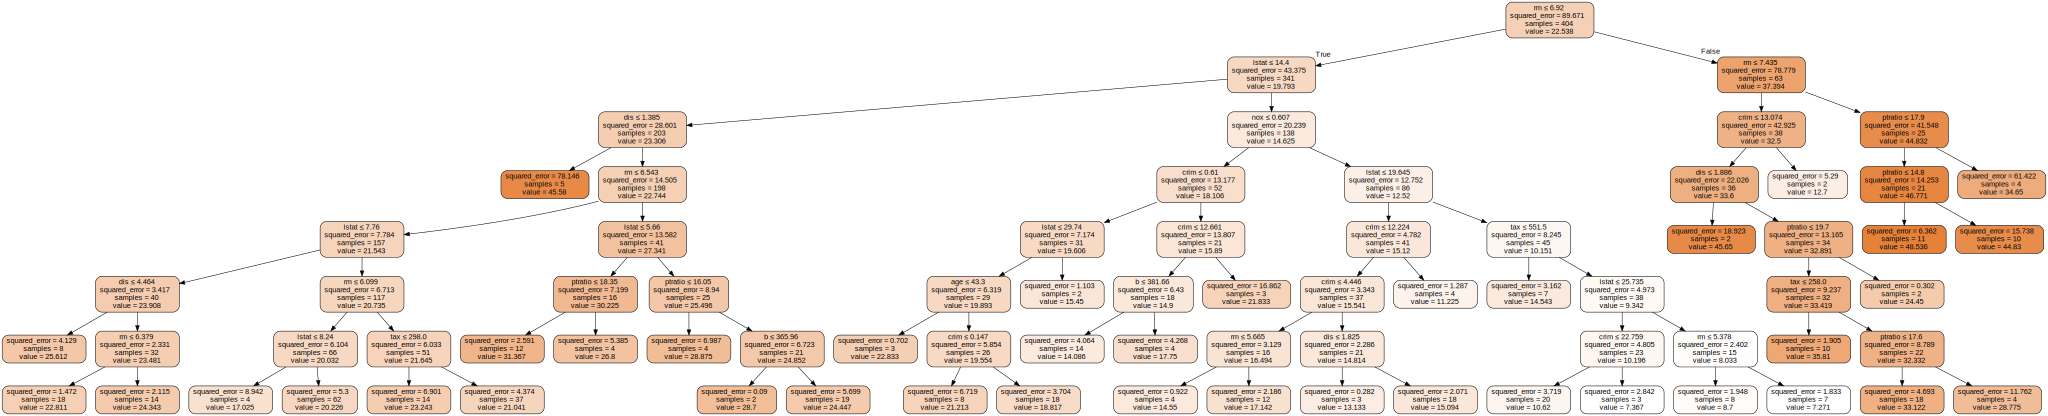

In [9]:
# Export tree structure
dot_data = export_graphviz(
    model, out_file=None, feature_names=x_train.columns, 
    filled=True, rounded=True, special_characters=True
)

# Display using graphviz
graph = graphviz.Source(dot_data)
graph  # Displays the tree in Jupyter Notebook

The tree is still a little big, but it feels much more possible to understand. If simple interpretability was very important to this project, we could further restrict the depth of the tree (even though it might slightly decrease our accuracy).